In [4]:
import os
from io import BytesIO
import matplotlib.pyplot as plt
import rawpy
import exifread
import numpy as np
from PIL import Image

In [22]:
raw_filename = 'Alexander_Flemming_2.ARW'
 
with rawpy.imread(raw_filename) as raw:
    print(f'raw type:                     {raw.raw_type}')                      # raw type (flat or stack, e.g., Foveon sensor)
    print(f'number of colors:             {raw.num_colors}')                    # number of different color components, e.g., 3 for common RGB Bayer sensors with two green identical green sensors 
    print(f'color description:            {raw.color_desc}')                    # describes the various color components
    print(f'raw pattern:                  {raw.raw_pattern.tolist()}')          # decribes the pattern of the Bayer sensor
    print(f'black levels:                 {raw.black_level_per_channel}')       # black level correction
    print(f'white level:                  {raw.white_level}')                   # camera white level
    print(f'color matrix:                 {raw.color_matrix.tolist()}')         # camera specific color matrix, usually obtained from a list in rawpy (not from the raw file)
    print(f'XYZ to RGB conversion matrix: {raw.rgb_xyz_matrix.tolist()}')       # camera specific XYZ to camara RGB conversion matrix
    print(f'camera white balance:         {raw.camera_whitebalance}')           # the picture's white balance as determined by the camera
    print(f'daylight white balance:       {raw.daylight_whitebalance}')         # the camera's daylight white balance

raw type:                     RawType.Flat
number of colors:             3
color description:            b'RGBG'
raw pattern:                  [[0, 1], [3, 2]]
black levels:                 [512, 512, 512, 512]
white level:                  16380
color matrix:                 [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]]
XYZ to RGB conversion matrix: [[0.6639999747276306, -0.18469999730587006, -0.0502999983727932], [-0.5238000154495239, 1.3009999990463257, 0.24740000069141388], [-0.09929999709129333, 0.1673000007867813, 0.6527000069618225], [0.0, 0.0, 0.0]]
camera white balance:         [2400.0, 1024.0, 1536.0, 1024.0]
daylight white balance:       [2.553339719772339, 0.932383120059967, 1.2761651277542114, 0.0]


In [23]:
with open(raw_filename, 'rb') as f:
    tags = exifread.process_file(f)
    for key, value in tags.items():
        if key is not 'JPEGThumbnail':  # do not print (uninteresting) binary thumbnail data
            print(f'{key}: {value}')

Image SubfileType: Reduced-resolution image
Image Compression: JPEG (old-style)
Image ImageDescription:                                
Image Make: SONY
Image Model: ILCE-7RM3
Image Orientation: Rotated 90 CCW
Image XResolution: 350
Image YResolution: 350
Image ResolutionUnit: Pixels/Inch
Image Software: ILCE-7RM3 v3.01
Image DateTime: 2020:02:16 18:37:06
Image SubIFDs: 130362
Image JPEGInterchangeFormat: 131234
Image JPEGInterchangeFormatLength: 440269
Image YCbCrPositioning: Co-sited
Image ApplicationNotes: []
Image ExifOffset: 4544
Image PrintIM: [80, 114, 105, 110, 116, 73, 77, 0, 48, 51, 48, 48, 0, 0, 3, 0, 2, 0, 1, 0, ... ]
Image Tag 0xC634: [120, 197, 0, 0]
Thumbnail SubfileType: Reduced-resolution image
Thumbnail Compression: JPEG (old-style)
Thumbnail ImageDescription:                                
Thumbnail Make: SONY
Thumbnail Model: ILCE-7RM3
Thumbnail Orientation: Rotated 90 CCW
Thumbnail XResolution: 72
Thumbnail YResolution: 72
Thumbnail ResolutionUnit: Pixels/Inch
Thu

<>:4: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:4: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-23-ce3e10d2104f>:4: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if key is not 'JPEGThumbnail':  # do not print (uninteresting) binary thumbnail data


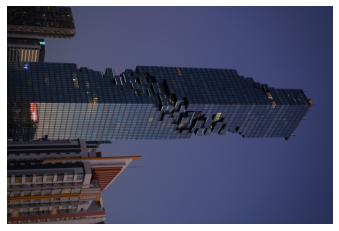

In [24]:
filename, _ = os.path.splitext(raw_filename)
with rawpy.imread(raw_filename) as raw:
    try:
        thumb = raw.extract_thumb()
    except rawpy.LibRawNoThumbnailError:
        print('no thumbnail found')
    else:
        if thumb.format in [rawpy.ThumbFormat.JPEG, rawpy.ThumbFormat.BITMAP]:
            if thumb.format is rawpy.ThumbFormat.JPEG:
                thumb_filename = filename + '_thumb.jpg'
                with open(thumb_filename, 'wb') as f:
                    f.write(thumb.data)
                thumb_rgb = Image.open(BytesIO(thumb.data))
            else:
                thumb_filename = filename + '_thumb.tiff'
                thumb_rgb = Image.fromarray(thumb.data)
                thumb_rgb.save(filename, 'tiff')
            plt.imshow(thumb_rgb)
            plt.axis('off')
        else:
            print('unknown thumbnail format')

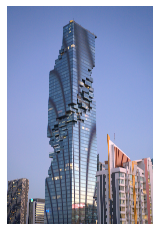

In [25]:
with rawpy.imread(raw_filename) as raw:
    image = raw.raw_image
    rgb = raw.postprocess(rawpy.Params(use_camera_wb=True))
    plt.imshow(rgb)
    plt.axis('off')

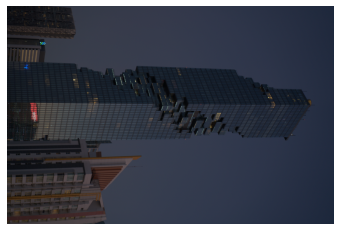

In [26]:
with rawpy.imread(raw_filename) as raw:
    # get raw image data
    image = np.array(raw.raw_image, dtype=np.double)
    # subtract black levels and normalize to interval [0..1]
    black = np.reshape(np.array(raw.black_level_per_channel, dtype=np.double), (2, 2))
    black = np.tile(black, (image.shape[0]//2, image.shape[1]//2))
    image = (image - black) / (raw.white_level - black)
    # find the positions of the three (red, green and blue) or four base colors within the Bayer pattern
    n_colors = raw.num_colors
    colors = np.frombuffer(raw.color_desc, dtype=np.byte)
    pattern = np.array(raw.raw_pattern)
    index_0 = np.where(colors[pattern] == colors[0])
    index_1 = np.where(colors[pattern] == colors[1])
    index_2 = np.where(colors[pattern] == colors[2])
    index_3 = np.where(colors[pattern] == colors[3])
    # apply white balance, normalize white balance coefficients to the 2nd coefficient, which is ususally the coefficient for green
    wb_c = raw.camera_whitebalance 
    wb = np.zeros((2, 2), dtype=np.double) 
    wb[index_0] = wb_c[0] / wb_c[1]
    wb[index_1] = wb_c[1] / wb_c[1]
    wb[index_2] = wb_c[2] / wb_c[1]
    if n_colors == 4:
        wb[index_3] = wb_c[3] / wb_c[1]
    wb = np.tile(wb, (image.shape[0]//2, image.shape[1]//2))
    image_wb = np.clip(image * wb, 0, 1)
    # demosaic via downsampling
    image_demosaiced = np.empty((image_wb.shape[0]//2, image_wb.shape[1]//2, n_colors))
    if n_colors == 3:
        image_demosaiced[:, :, 0] = image_wb[index_0[0][0]::2, index_0[1][0]::2]
        image_demosaiced[:, :, 1]  = (image_wb[index_1[0][0]::2, index_1[1][0]::2] + image_wb[index_1[0][1]::2, index_1[1][1]::2]) / 2
        image_demosaiced[:, :, 2]  = image_wb[index_2[0][0]::2, index_2[1][0]::2]
    else: # n_colors == 4
        image_demosaiced[:, :, 0] = image_wb[index_0[0][0]::2, index_0[1][0]::2]
        image_demosaiced[:, :, 1] = image_wb[index_1[0][0]::2, index_1[1][0]::2]
        image_demosaiced[:, :, 2] = image_wb[index_2[0][0]::2, index_2[1][0]::2]
        image_demosaiced[:, :, 3] = image_wb[index_3[0][0]::2, index_3[1][0]::2]
    # convert to linear sRGB, calculate the matrix that transforms sRGB into the camera's primary color components and invert this matrix to perform the inverse transformation
    XYZ_to_cam = np.array(raw.rgb_xyz_matrix[0:n_colors, :], dtype=np.double)
    sRGB_to_XYZ = np.array([[0.4124564, 0.3575761, 0.1804375],
                            [0.2126729, 0.7151522, 0.0721750],
                            [0.0193339, 0.1191920, 0.9503041]], dtype=np.double)
    sRGB_to_cam = np.dot(XYZ_to_cam, sRGB_to_XYZ)
    norm = np.tile(np.sum(sRGB_to_cam, 1), (3, 1)).transpose()
    sRGB_to_cam = sRGB_to_cam / norm
    if n_colors == 3:
        cam_to_sRGB = np.linalg.inv(sRGB_to_cam)
    else: # n_colors == 4
        cam_to_sRGB = np.linalg.pinv(sRGB_to_cam)
    image_sRGB = np.einsum('ij,...j', cam_to_sRGB, image_demosaiced)  # performs the matrix-vector product for each pixel
    # apply sRGB gamma curve
    i = image_sRGB < 0.0031308
    j = np.logical_not(i)
    image_sRGB[i] = 323 / 25 * image_sRGB[i]
    image_sRGB[j] = 211 / 200 * image_sRGB[j] ** (5 / 12) - 11 / 200
    image_sRGB = np.clip(image_sRGB, 0, 1)
    # show image
    plt.axis('off')
    plt.imshow(image_sRGB)

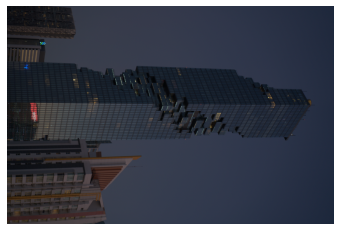

In [27]:
with rawpy.imread(raw_filename) as raw:
    # get raw image data
    image = np.array(raw.raw_image, dtype=np.double)
    # subtract black levels and normalize to interval [0..1]
    black = np.reshape(np.array(raw.black_level_per_channel, dtype=np.double), (2, 2))
    black = np.tile(black, (image.shape[0]//2, image.shape[1]//2))
    image = (image - black) / (raw.white_level - black)
    # find the positions of the three (red, green and blue) or four base colors within the Bayer pattern
    n_colors = raw.num_colors
    colors = np.frombuffer(raw.color_desc, dtype=np.byte)
    pattern = np.array(raw.raw_pattern)
    index_0 = np.where(colors[pattern] == colors[0])
    index_1 = np.where(colors[pattern] == colors[1])
    index_2 = np.where(colors[pattern] == colors[2])
    index_3 = np.where(colors[pattern] == colors[3])
    # apply white balance, normalize white balance coefficients to the 2nd coefficient, which is ususally the coefficient for green
    wb_c = raw.camera_whitebalance 
    wb = np.zeros((2, 2), dtype=np.double) 
    wb[index_0] = wb_c[0] / wb_c[1]
    wb[index_1] = wb_c[1] / wb_c[1]
    wb[index_2] = wb_c[2] / wb_c[1]
    if n_colors == 4:
        wb[index_3] = wb_c[3] / wb_c[1]
    wb = np.tile(wb, (image.shape[0]//2, image.shape[1]//2))
    image_wb = np.clip(image * wb, 0, 1)
    # demosaic via downsampling
    image_demosaiced = np.empty((image_wb.shape[0]//2, image_wb.shape[1]//2, n_colors))
    if n_colors == 3:
        image_demosaiced[:, :, 0] = image_wb[index_0[0][0]::2, index_0[1][0]::2]
        image_demosaiced[:, :, 1] = (image_wb[index_1[0][0]::2, index_1[1][0]::2] + image_wb[index_1[0][1]::2, index_1[1][1]::2]) / 2
        image_demosaiced[:, :, 2] = image_wb[index_2[0][0]::2, index_2[1][0]::2]
    else: # n_colors == 4
        image_demosaiced[:, :, 0] = image_wb[index_0[0][0]::2, index_0[1][0]::2]
        image_demosaiced[:, :, 1] = image_wb[index_1[0][0]::2, index_1[1][0]::2]
        image_demosaiced[:, :, 2] = image_wb[index_2[0][0]::2, index_2[1][0]::2]
        image_demosaiced[:, :, 3] = image_wb[index_3[0][0]::2, index_3[1][0]::2]
    # convert to linear sRGB, calculate the matrix that transforms sRGB into the camera's primary color components and invert this matrix to perform the inverse transformation
    XYZ_to_cam = np.array(raw.rgb_xyz_matrix[0:n_colors, :], dtype=np.double)
    sRGB_to_XYZ = np.array([[0.4124564, 0.3575761, 0.1804375],
                            [0.2126729, 0.7151522, 0.0721750],
                            [0.0193339, 0.1191920, 0.9503041]], dtype=np.double)
    sRGB_to_cam = np.dot(XYZ_to_cam, sRGB_to_XYZ)
    norm = np.tile(np.sum(sRGB_to_cam, 1), (3, 1)).transpose()
    sRGB_to_cam = sRGB_to_cam / norm
    if n_colors == 3:
        cam_to_sRGB = np.linalg.inv(sRGB_to_cam)
    else: # n_colors == 4
        cam_to_sRGB = np.linalg.pinv(sRGB_to_cam)
    image_sRGB = np.einsum('ij,...j', cam_to_sRGB, image_demosaiced)  # performs the matrix-vector product for each pixel
    # apply sRGB gamma curve
    i = image_sRGB < 0.0031308
    j = np.logical_not(i)
    image_sRGB[i] = 323 / 25 * image_sRGB[i]
    image_sRGB[j] = 211 / 200 * image_sRGB[j] ** (5 / 12) - 11 / 200
    image_sRGB = np.clip(image_sRGB, 0, 1)
    # show image
    plt.axis('off')
    plt.imshow(image_sRGB)

In [28]:
import imageio

In [29]:
imageio.imwrite('srgb_io.jpeg', image_sRGB)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
